# Função da tomografia 

## Atualização da função `tomography`

A seguir apresentamos as mudanças realizadas para que a tomografia funcione mesmo em circuitos que já contenham bits clássicos:

---

### Coleta de resultados

**Antes**

```python
p0 = counts.get('0', 0)
p1 = counts.get('1', 0)
```

* Assumíamos que as chaves de `counts` eram exatamente `"0"` ou `"1"`.
* Com bits clássicos pré‑existentes, as chaves passaram a ser strings como `"00"`, `"01"`, etc., e os métodos `.get('0')` e `.get('1')` voltavam zero sempre.

**Depois**

```python
p0 = sum(cnt for bits, cnt in counts.items() if bits[0]=='0')
p1 = sum(cnt for bits, cnt in counts.items() if bits[0]=='1')
```

* Filtramos pelo **primeiro** caractere de cada chave (`bits[0]`), que corresponde ao nosso bit `c_tom[0]`.
* Assim somamos corretamente todas as contagens em que o registro de tomografia saiu 0 ou 1, **independentemente** de quantos outros bits clássicos existem no circuito.

In [1]:
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
import scipy.linalg as la
from qiskit.exceptions import QiskitError
from qiskit.quantum_info.states.statevector import Statevector
from qiskit.quantum_info.states.densitymatrix import DensityMatrix
from qiskit.quantum_info.states.utils import (
    partial_trace,
    shannon_entropy,
    _format_state,
    _funm_svd,
)

pauli_list = [
    np.eye(2),
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]

bases = {
    'I': pauli_list[0],
    'X': pauli_list[1],
    'Y': pauli_list[2],
    'Z': pauli_list[3],
}

backend=AerSimulator()

# Aplica transformação de base + medida
def measurement_circuit(base, input_circuit, target):
    circuit = input_circuit.copy()
    
    if base == 'X':
        circuit.h(target)
    elif base == 'Y':
        circuit.sdg(target)
        circuit.h(target)
    
    creg = ClassicalRegister(1, 'c_tom')
    circuit.add_register(creg)
    circuit.measure(target, creg[0])

    return circuit

def tomography(my_circuit, target, shots):
    expectation_values = {}
    all_counts = {}

    for base in ['X','Y','Z']:
        circ       = measurement_circuit(base, my_circuit, target)
        transpiled = transpile(circ, backend)
        result     = backend.run(transpiled, shots=shots).result()
        counts     = result.get_counts()

        # Agora filtramos o primeiro bit da string (bits[0]), que corresponde a c_tom[0]
        p0 = sum(cnt for bits, cnt in counts.items() if bits[0]=='0')
        p1 = sum(cnt for bits, cnt in counts.items() if bits[0]=='1')
        total = p0 + p1 or 1

        expectation_values[base] = (p0 - p1) / total
        all_counts[base] = counts

    rho = 0.5 * (
        pauli_list[0]
        + expectation_values['X'] * pauli_list[1]
        + expectation_values['Y'] * pauli_list[2]
        + expectation_values['Z'] * pauli_list[3]
    )

    return rho, expectation_values

# Circuito que gera qubits emaranhados

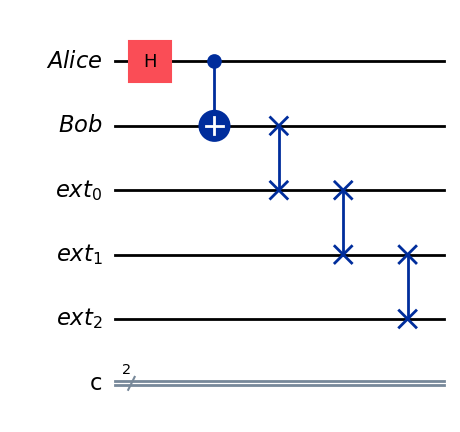

In [2]:
from qiskit import *

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def entanglement(n=0):
    # 1) Cria registradores quânticos Alice e Bob
    alice = QuantumRegister(1, 'Alice')
    bob   = QuantumRegister(1, 'Bob')
    regs_q = [alice, bob]

    # 2) Se n>0, adiciona registrador extra "ext" com n qubits
    if n > 0:
        ext = QuantumRegister(n, 'ext')
        regs_q.append(ext)

    # 3) Cria registrador clássico com 1 bit
    c = ClassicalRegister(2, 'c')

    # 4) Monta o circuito incluindo TODOS os registradores
    qc = QuantumCircuit(*regs_q, c, name=f'entanglement(n={n})')

    # 5) Prepara o par de Bell entre Alice e Bob
    qc.h(alice[0])
    qc.cx(alice[0], bob[0])

    # 6) Se n>0, aplica cadeia de swaps: Bob ↔ ext[0] ↔ ext[1] ↔ …
    if n > 0:
        qc.swap(bob[0], ext[0])
        for i in range(1, n):
            qc.swap(ext[i-1], ext[i])

    return qc

# Exemplos:
c3 = entanglement(3)
display(c3.draw('mpl'))        # idem




In [3]:
rho_0= tomography(c3, target=0, shots=100000)
rho_1 = tomography(c3, target=1, shots=100000)
rho_2 = tomography(c3, target=2, shots=100000)
rho_3 = tomography(c3, target=3, shots=100000)
rho_4 = tomography(c3, target=4, shots=100000)

print(rho_0)
print(rho_1)
print(rho_2)
print(rho_3)
print(rho_4)

(array([[0.49993+0.j     , 0.00104+0.00069j],
       [0.00104-0.00069j, 0.50007+0.j     ]]), {'X': 0.00208, 'Y': -0.00138, 'Z': -0.00014})
(array([[ 1.0e+00+0.j     , -2.8e-04+0.00059j],
       [-2.8e-04-0.00059j,  0.0e+00+0.j     ]]), {'X': -0.00056, 'Y': -0.00118, 'Z': 1.0})
(array([[ 1.     +0.j    , -0.00111-0.0013j],
       [-0.00111+0.0013j,  0.     +0.j    ]]), {'X': -0.00222, 'Y': 0.0026, 'Z': 1.0})
(array([[ 1.     +0.j     , -0.00159+0.00152j],
       [-0.00159-0.00152j,  0.     +0.j     ]]), {'X': -0.00318, 'Y': -0.00304, 'Z': 1.0})
(array([[ 0.5004+0.j     , -0.0019+0.00058j],
       [-0.0019-0.00058j,  0.4996+0.j     ]]), {'X': -0.0038, 'Y': -0.00116, 'Z': 0.0008})
